# BIOINFORMATICS 
## Class – PROJECT part 2 Neuroscience application
### Brain network study during resting states


In [1]:
import numpy as np
from connectivipy import mvar_gen
import connectivipy as cp
import pandas as pd
import csv
import matplotlib.pyplot as plt
from tqdm import tnrange, tqdm_notebook
import networkx as nx

In [2]:
# Importing Data

df01 = pd.read_csv('S070-R01-all.csv', skiprows= [1,2], index_col= [0])
df01 = df01[df01.columns[:-1]]

df02 = pd.read_csv('S070-R02-all.csv', skiprows= [1,2], index_col= [0])
df02 = df02[df02.columns[:-1]]

In [3]:
# to merge the 2 df

df = pd.concat([df01,df02], ignore_index=True).T

# we took Transposed matrix to fit the data shape 

### Connectivity graph
1.1. (​mandatory​​) Estimate functional brain connectivity among 64 channels using one of the
MVAR estimators: Partial Directed Coherence (PDC), Direct Transfer Function (DTF). Select one relevant frequency value. Apply a threshold so that the resulting binary connectivity matrices have network density equal to 20%. Create a graphical representation of the binary adjacency matrix.

In [ ]:
# Create a copy of the data to work on

In [516]:
A3 = df.copy()

In [5]:
fs = 10

In [6]:
channels = ['Fc5','Fc3','Fc1','Fcz','Fc2','Fc4','Fc6','C5','C3','C1','Cz','C2','C4','C6','Cp5','Cp3','Cp1','Cpz','Cp2','Cp4','Cp6','Fp1','Fpz','Fp2','Af7','Af3','Afz','Af4','Af8','F7','F5','F3','F1','Fz','F2','F4','F6','F8','Ft7','Ft8','T7','T8','T9','T10','Tp7','Tp8','P7','P5','P3','P1','Pz','P2','P4','P6','P8','Po7','Po3','Poz','Po4','Po8','O1','Oz','O2','Iz']

In [517]:
data3 = cp.Data(A3.values, 64, channels)

In [518]:
data3.fit_mvar(2, 'yw')

In [9]:
ar, vr = data3.mvar_coefficients

Using Direct Transfer Function (DTF)

In [519]:
gdtf_values = data3.conn('gdtf')

In [171]:
gdtf_values[0]

array([[0.00133915, 0.20039474, 0.03228255, ..., 0.20971151, 0.02846999,
        0.34726535],
       [0.11639059, 0.3671986 , 0.04761378, ..., 0.19789102, 0.01914025,
        0.38294933],
       [0.07939346, 0.23421671, 0.06744662, ..., 0.25176635, 0.05703355,
        0.43745917],
       ...,
       [0.04222067, 0.14945177, 0.03501108, ..., 0.32500279, 0.01835239,
        0.08841604],
       [0.047226  , 0.15371797, 0.02734635, ..., 0.06984467, 0.24562143,
        0.00240999],
       [0.02598069, 0.06070925, 0.03000965, ..., 0.32150271, 0.12477143,
        0.424285  ]])

Get the coefficient significance values 

In [520]:
gdtf_significance = data3.significance(Nrep=10, alpha=0.05)

. . . . . . . . . . |


/Users/ismail/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


In [26]:
plt.rcParams["figure.figsize"] = (20,20)

In order to get the density of 20%, we will sort the CC values and get the top 20%, and then consider the thresold equales to the minimum value of the 20%.

In [521]:
con_values = [gdtf_significance[i][j] for i in range(64) for j in range(64)]

In [522]:
con_values = sorted(con_values)

In [523]:
threshold = con_values[int(len(con_values)*0.8):][0]

Now we have the value of the thresold, we use it to build the adjacency matrix, by considering this value it as the connectivity threshold value.

In [176]:
threshold

0.03327723375772107

We create an adjacency matrix, considering the above threshold.
then we plot this graph using this matrix

In [524]:
adj_mat = [ [0 for i in range(64)] for j in range(64)]
for i in range(64):
    for j in range(64):
        if gdtf_significance[i][j]>threshold:
            adj_mat[i][j]=1


In [525]:
G_dtf = nx.DiGraph(np.array(adj_mat))

Renaming the nodes

In [526]:
mapping = {old:channels[old] for old in G_dtf }

In [527]:
G_dtf = nx.relabel_nodes(G_dtf, mapping)

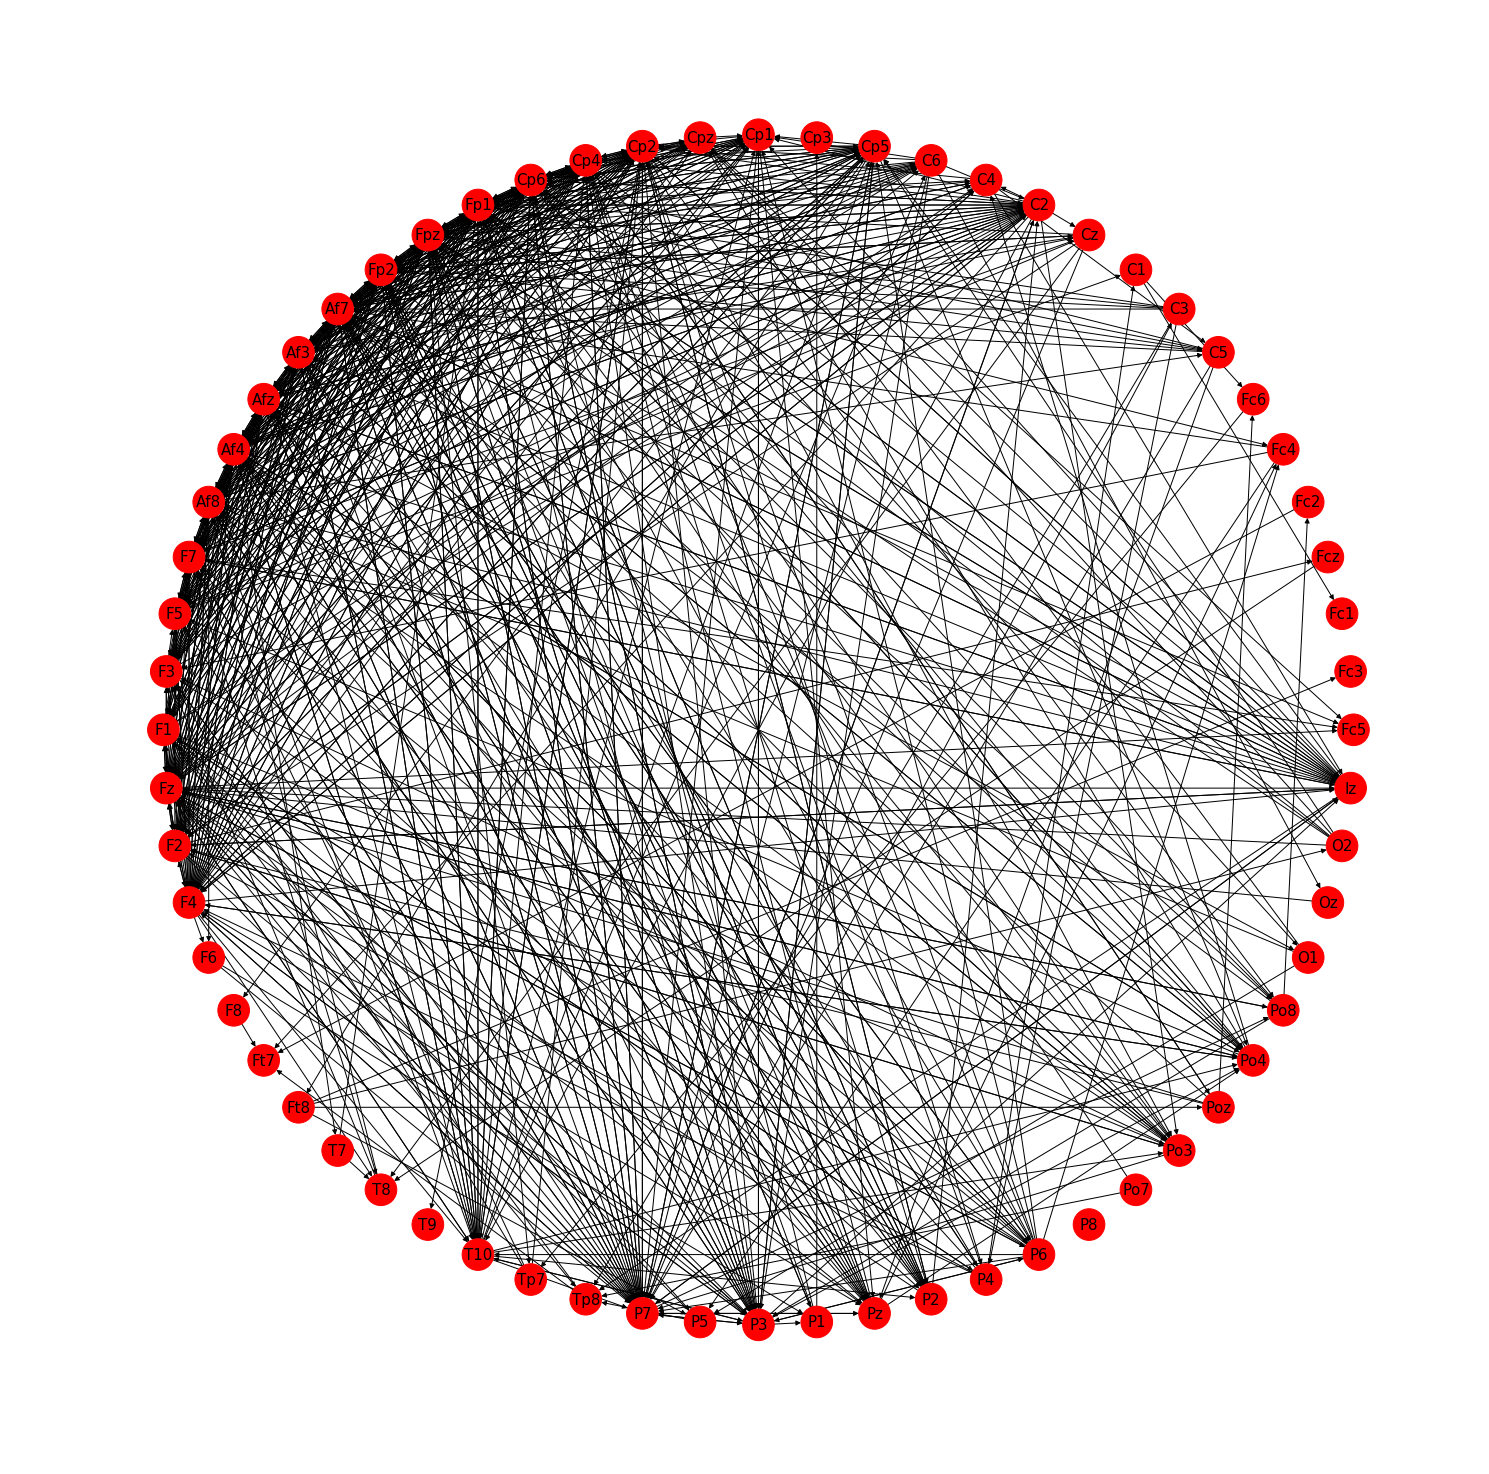

In [24]:
pos = nx.circular_layout(G_dtf)
nx.draw(G_dtf, with_labels = True, pos=pos, font_size=15, node_size=[1000]*64)

 We can notice that some channels (between C2 and F4) are far more connected to other channels. There is only one isolated channel (P8)

Now we check the denity again:

In [528]:
nx.density(G_dtf)

0.203125

### 1.2 
PDC stimation with graph (point 1.3)
point 1.1 done with DTF


In [106]:
A = np.zeros((1, 64, 64))
for i in range(64):
    for j in range(64):
        A[0][i][j] = A3.values[i][j]

In [107]:
# now we build a corresponding MVAR process without instantenous effect
L = np.linalg.inv(np.eye(64) - A)
acf = np.zeros((1, 64, 64))
for i in range(1):
    acf[i] = np.dot(L, A[0])


In [139]:

# generate 5-channel signals from matrix above
signal_inst = cp.mvar_gen_inst(A, int(10e4))

signal = cp.mvar_gen(acf, 64)

# fit MVAR parameters
bv, vfb = cp.Mvar.fit(signal_inst, 1, 'yw')

av, vfa = cp.Mvar.fit(signal, 1, 'yw')


# use connectivity estimators
ipdc = cp.conn.iPDC()
ipdcval = ipdc.calculate(bv, vfb, 1.)

pdc = cp.conn.PDC()
pdcval = pdc.calculate(av, vfa, 1.)



In [140]:

mat_max = np.zeros((64,64))
n = 0
idx = ''
for i in range(100):
    aux = pdcval[i]
    m = aux>mat_max
    m = list(m)
    r = sum([list(el).count(True) for el in m])
    if r > n:
        idx = i
        n = r
        mat_max = pdcval[i]

In [141]:

con_values = [mat_max[i][j] for i in range(64) for j in range(64)]

con_values = sorted(con_values)

threshold = con_values[int(len(con_values)*0.8):][0]
print(threshold)


0.12742942206889737


In [150]:
adj_mat_pdc = [ [0 for i in range(64)] for j in range(64)]
for i in range(64):
    for j in range(64):
        if mat_max[i][j]>threshold:
            adj_mat_pdc[i][j]=1



In [ ]:
sorted(con_values)

In [151]:

G_pdc = nx.DiGraph(np.array(adj_mat_pdc))
mapping = {old:channels[old] for old in G_pdc }
G_pdc = nx.relabel_nodes(G_pdc, mapping)


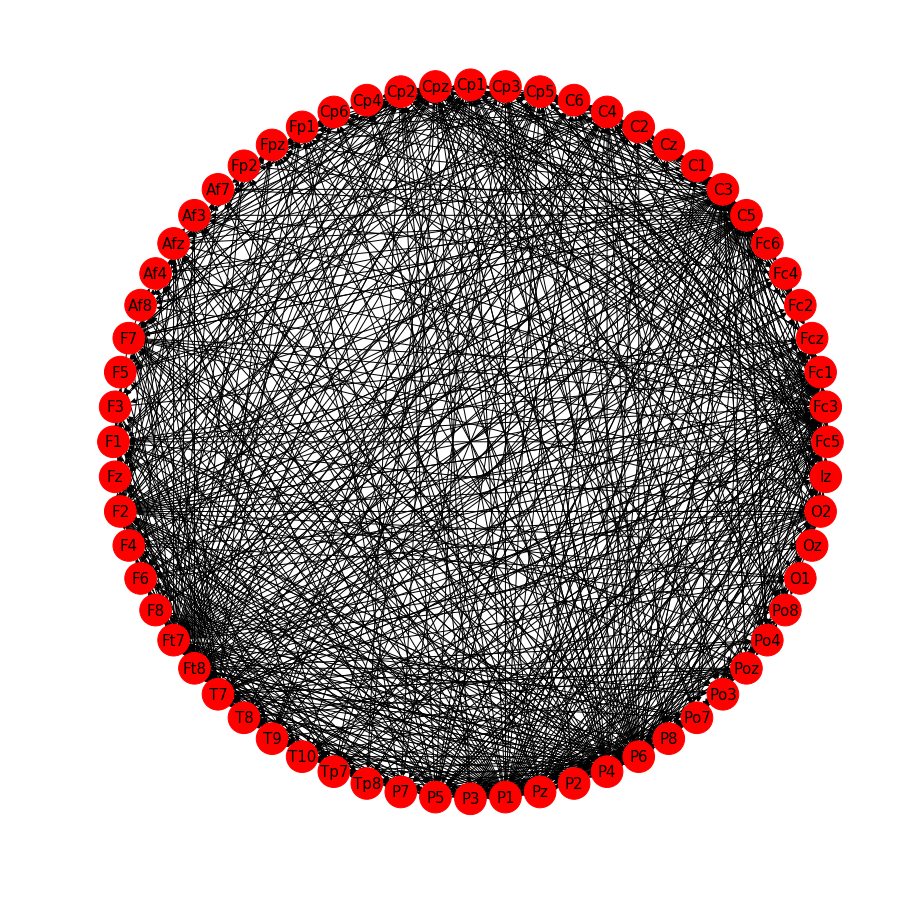

In [152]:

pos = nx.circular_layout(G_pdc)
plt.figure(figsize=(12,12))
nx.draw(G_pdc, with_labels = True, pos=pos, font_size=15, node_size=[1000]*64)

### 1.3 (class ‘A’) 
Perform task 1.1 using thresholds yielding the following density values: 1%, 5%,
10%, 20%, 30%, 50%.

In [177]:
threshold_01 = con_values[int(len(con_values)*0.99):][0]
threshold_05 = con_values[int(len(con_values)*0.95):][0]
threshold_10 = con_values[int(len(con_values)*0.90):][0]
threshold_20 = con_values[int(len(con_values)*0.80):][0]
threshold_30 = con_values[int(len(con_values)*0.70):][0]
threshold_50 = con_values[int(len(con_values)*0.50):][0]

In [178]:
adj_mat_01 = [ [0 for i in range(64)] for j in range(64)]
adj_mat_05 = [ [0 for i in range(64)] for j in range(64)]
adj_mat_10 = [ [0 for i in range(64)] for j in range(64)]
adj_mat_20 = [ [0 for i in range(64)] for j in range(64)]
adj_mat_30 = [ [0 for i in range(64)] for j in range(64)]
adj_mat_50 = [ [0 for i in range(64)] for j in range(64)]

for i in range(64):
    for j in range(64):
        if gdtf_significance[i][j]>threshold_01: adj_mat_01[i][j]=1
        if gdtf_significance[i][j]>threshold_05: adj_mat_05[i][j]=1
        if gdtf_significance[i][j]>threshold_10: adj_mat_10[i][j]=1
        if gdtf_significance[i][j]>threshold_20: adj_mat_20[i][j]=1
        if gdtf_significance[i][j]>threshold_30: adj_mat_30[i][j]=1
        if gdtf_significance[i][j]>threshold_50: adj_mat_50[i][j]=1


In [180]:
threshold_01

0.9972100981673221

In [45]:
con_values[-1]

0.9990177894485471

In [51]:
plt.rcParams["figure.figsize"] = (10,10)

In [181]:
G_dtf_05 = nx.DiGraph(np.array(adj_mat_05))

In [48]:
mapping = {old:channels[old] for old in G_dtf_05}

In [49]:
G_dtf_05 = nx.relabel_nodes(G_dtf_05, mapping)

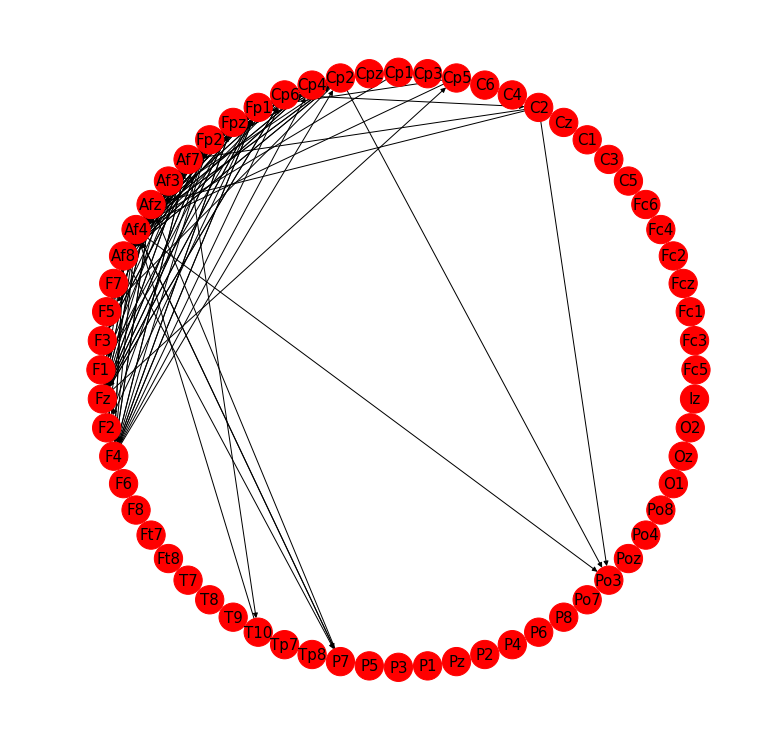

In [53]:
pos_05 = nx.circular_layout(G_dtf_05)
nx.draw(G_dtf_05, with_labels = True, pos=pos_05, font_size=15, node_size=[800]*64)

In [182]:
G_dtf_01 = nx.DiGraph(np.array(adj_mat_01))

In [55]:
mapping = {old:channels[old] for old in G_dtf_01}

In [56]:
G_dtf_01 = nx.relabel_nodes(G_dtf_01, mapping)

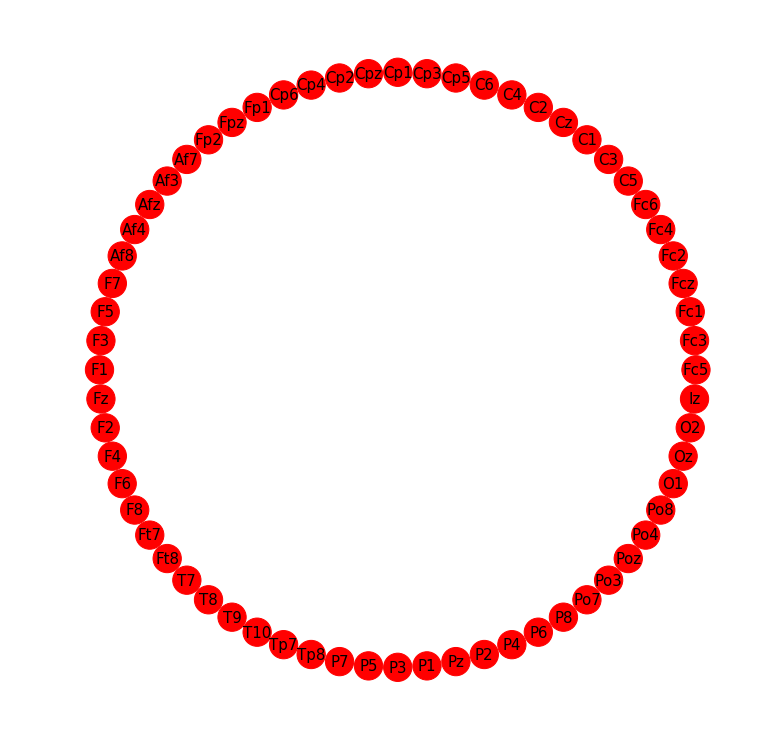

In [57]:
pos_01 = nx.circular_layout(G_dtf_01)
nx.draw(G_dtf_01, with_labels = True, pos=pos_01, font_size=15, node_size=[800]*64)

In [183]:
G_dtf_10 = nx.DiGraph(np.array(adj_mat_10))

In [59]:
mapping = {old:channels[old] for old in G_dtf_10}

In [60]:
G_dtf_10 = nx.relabel_nodes(G_dtf_10, mapping)

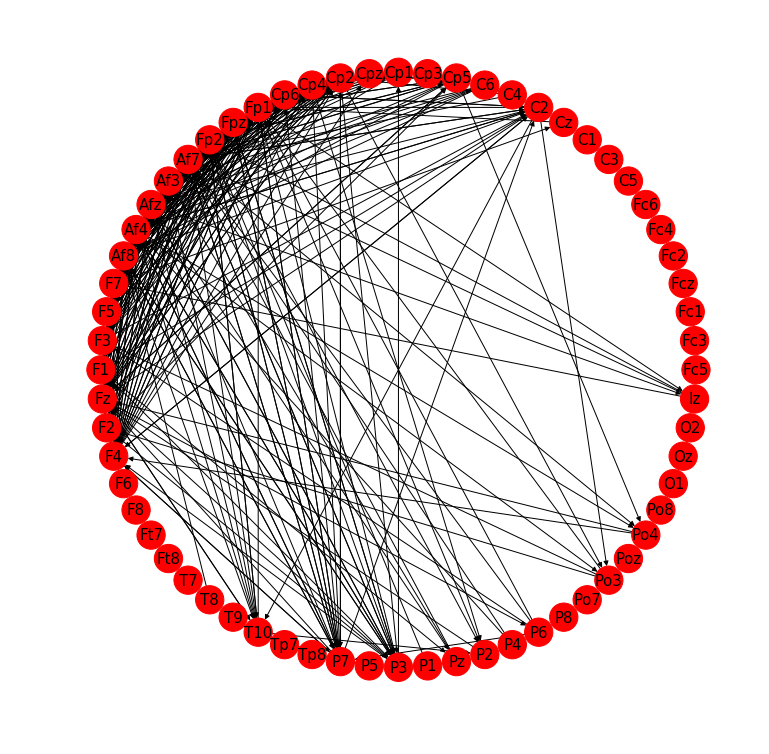

In [61]:
pos_10 = nx.circular_layout(G_dtf_10)
nx.draw(G_dtf_10, with_labels = True, pos=pos_10, font_size=15, node_size=[800]*64)

In [184]:
G_dtf_20 = nx.DiGraph(np.array(adj_mat_20))

In [63]:
mapping = {old:channels[old] for old in G_dtf_20}

In [64]:
G_dtf_20 = nx.relabel_nodes(G_dtf_20, mapping)

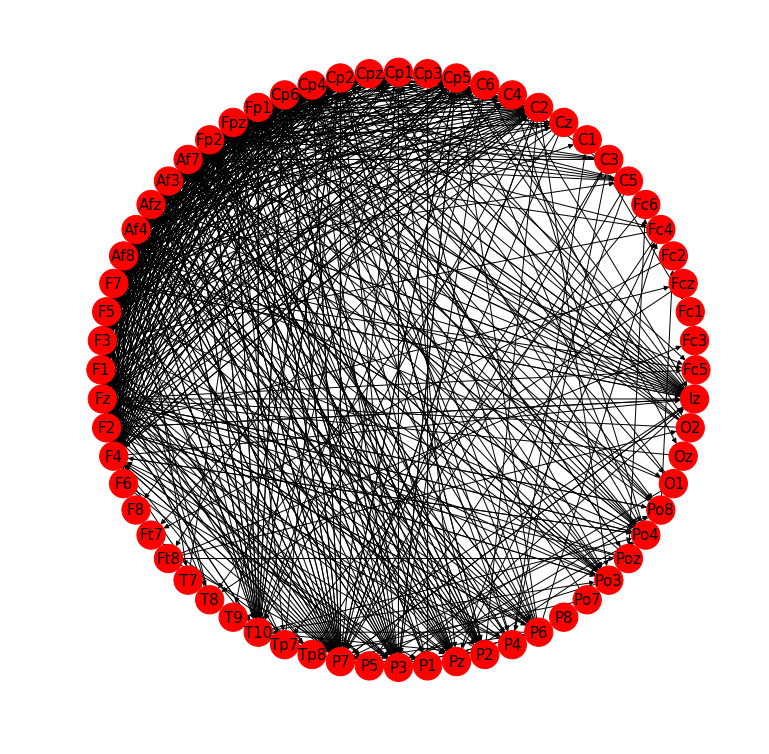

In [65]:
pos_20 = nx.circular_layout(G_dtf_20)
nx.draw(G_dtf_20, with_labels = True, pos=pos_20, font_size=15, node_size=[800]*64)

In [185]:
G_dtf_30 = nx.DiGraph(np.array(adj_mat_30))

In [67]:
mapping = {old:channels[old] for old in G_dtf_30}

In [68]:
G_dtf_30 = nx.relabel_nodes(G_dtf_30, mapping)

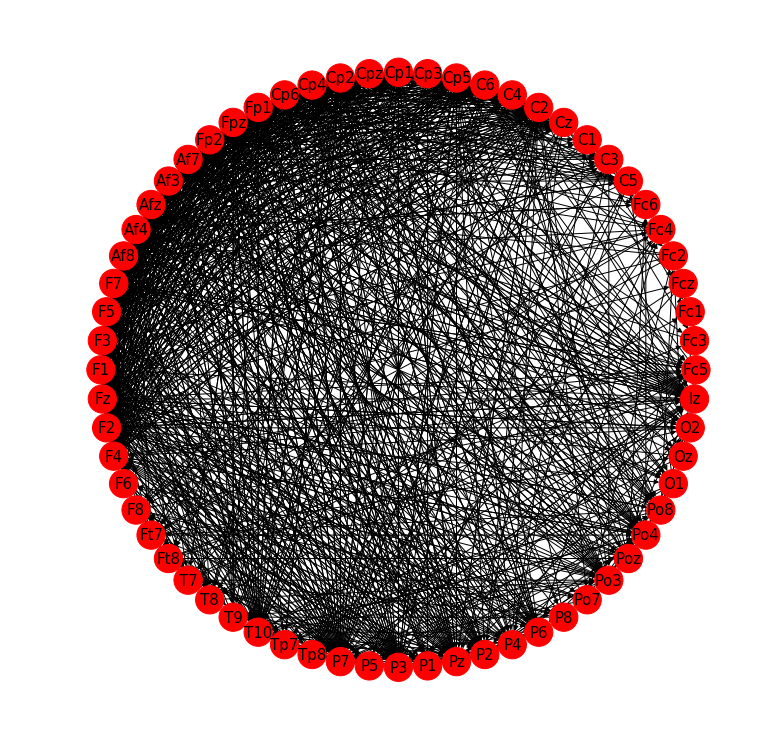

In [69]:
pos_30 = nx.circular_layout(G_dtf_30)
nx.draw(G_dtf_30, with_labels = True, pos=pos_30, font_size=15, node_size=[800]*64)

In [186]:
G_dtf_50 = nx.DiGraph(np.array(adj_mat_50))

In [71]:
mapping = {old:channels[old] for old in G_dtf_50}

In [72]:
G_dtf_50 = nx.relabel_nodes(G_dtf_50, mapping)

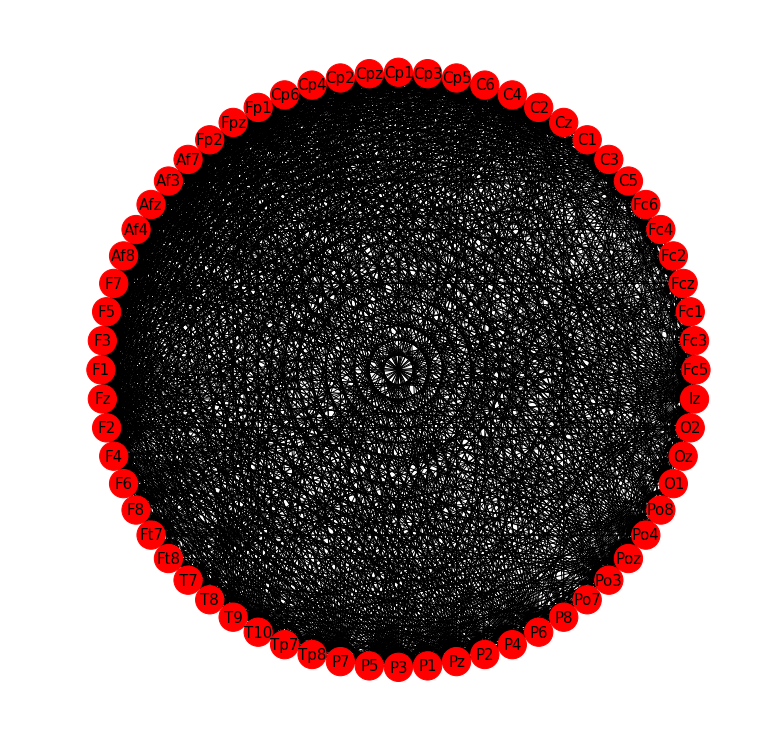

In [73]:
pos_50 = nx.circular_layout(G_dtf_50)
nx.draw(G_dtf_50, with_labels = True, pos=pos_50, font_size=15, node_size=[800]*64)

### 1.5

In [585]:
reduced_channels = ["Fp1","Fp2","F7","F3","Fz", "F4", "F8", "T7","C3","Cz","C4","T8","P7","P3","Pz","P4","P8","O1", "O2"]

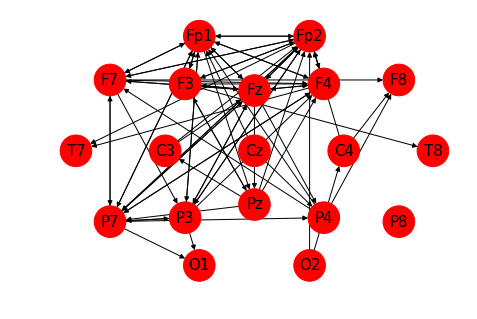

In [38]:
pos = {}
with open("channel_locations.txt") as f:
    next(f)
    c = csv.reader(f)
    for line in c:
        line = line[0]
        line=line.split('        ')
        pos[line[1]] = (float(line[2]), float(line[3]))

# Topographical representation
sub = G_1.subgraph(reduced_channels)

nx.draw(sub, with_labels = True, pos=pos, font_size=15, node_size=[1000]*64)

# task 2.1

In [132]:
G_dtf

In [133]:
G_dtf.nodes()

NodeView(('Fc5', 'Fc3', 'Fc1', 'Fcz', 'Fc2', 'Fc4', 'Fc6', 'C5', 'C3', 'C1', 'Cz', 'C2', 'C4', 'C6', 'Cp5', 'Cp3', 'Cp1', 'Cpz', 'Cp2', 'Cp4', 'Cp6', 'Fp1', 'Fpz', 'Fp2', 'Af7', 'Af3', 'Afz', 'Af4', 'Af8', 'F7', 'F5', 'F3', 'F1', 'Fz', 'F2', 'F4', 'F6', 'F8', 'Ft7', 'Ft8', 'T7', 'T8', 'T9', 'T10', 'Tp7', 'Tp8', 'P7', 'P5', 'P3', 'P1', 'Pz', 'P2', 'P4', 'P6', 'P8', 'Po7', 'Po3', 'Poz', 'Po4', 'Po8', 'O1', 'Oz', 'O2', 'Iz'))

In [134]:
G_dtf.is_directed()

True

In [140]:
def check_symmetric(a, tol=1e-8):
    return np.allclose(a, a.T, atol=tol)

In [141]:
check_symmetric(gdtf_significance)

False

2.1 Global Clustering Coefficient:


In [529]:
nx.average_clustering(G_dtf.to_undirected())

0.5549611432367636

2.1 Path lengthe:

In [530]:
nx.average_shortest_path_length(G_dtf)

1.765625

In [116]:
tmpList = []
for n in G_1.nodes():
    tmpList.append([n, G_dtf.degree(n),G_dtf.in_degree(n),G_dtf.out_degree(n)])
nodes_df = pd.DataFrame(tmpList, columns=['Node','Degree', 'In', 'Out'])



Now we select the top ten nodes (based on number of their degrees)

In [117]:
nodes_top10 = nodes_df.sort_values(by='Degree', ascending=False).head(10)

In [118]:
nodes_top10

Node  Degree  In  Out
24  Af7      73  39   34
21  Fp1      67  36   31
22  Fpz      66  33   33
33   Fz      65  33   32
27  Af4      64  31   33
23  Fp2      61  32   29
26  Afz      58  28   30
20  Cp6      56  28   28
28  Af8      56  30   26
35   F4      55  24   31

### 2.2 (class ‘D’) 
Search in the literature a definition of small-worldness index (i.e. an index
describing the small-world organization of a network) and compute it.

Small world networks could be recognized by their not-small clustering coefficient and short path lenght,
and this is what we can notice in our graph with CC = 0.52, and shortest path L = 1.99.

Hereunder we will create a random small world network with the same number of nodes and similar degree probability using Erdos Renyi algorith, and then compare its indices to our graph ones:

In [502]:
# the average degree:
nodes_df['Degree'].mean()/len(nodes_df)

0.39990234375

In [506]:
erdos = nx.erdos_renyi_graph(64,0.4, directed=True)

In [507]:
nx.average_clustering(erdos.to_undirected())

0.6388776780989694

In [508]:
nx.average_shortest_path_length(erdos)

1.6063988095238095

### 2.3 (class ‘B’) 
Compare the global indices extracted from PDC and DTF connectivity
estimations.

In [509]:
G_dtf
nx.average_clustering(G_dtf.to_undirected())

0.6976883228525191

In [153]:
G_pdc
nx.average_clustering(G_pdc.to_undirected())

0.6437981099380977

In [513]:
nx.average_shortest_path_length(G_dtf)

0.9722222222222222

In [154]:
nx.average_shortest_path_length(G_pdc)

0.8467261904761905

### 2.4 (class ‘C’) 
Study the behaviour of global graph indices in function of network density (see
point 2.3 for density values).

In [582]:
print ('CC of graph of desnisty 0.01 ', nx.average_clustering(G_dtf_01.to_undirected()))
print ('CC of graph of desnisty 0.05 ', nx.average_clustering(G_dtf_05.to_undirected()))
print ('CC of graph of desnisty 0.10 ', nx.average_clustering(G_dtf_10.to_undirected()))
print ('CC of graph of desnisty 0.20 ', nx.average_clustering(G_dtf_20.to_undirected()))
print ('CC of graph of desnisty 0.30 ', nx.average_clustering(G_dtf_30.to_undirected()))
print ('CC of graph of desnisty 0.50 ', nx.average_clustering(G_dtf_50.to_undirected()))

CC of graph of desnisty 0.01  0.0
CC of graph of desnisty 0.05  0.2487725943378517
CC of graph of desnisty 0.10  0.40452085608108457
CC of graph of desnisty 0.20  0.557310890428274
CC of graph of desnisty 0.30  0.5761395587802903
CC of graph of desnisty 0.50  0.7176182189689552


In [583]:
# since the G_i is not a connected graph we will calculate the average path length for each connected component:
sh_i = 0
n_i = 0
for g in nx.connected_component_subgraphs(G_dtf_01.to_undirected()):
    sh_i += nx.average_shortest_path_length(g) * nx.number_of_nodes(g)
    n_i += nx.number_of_nodes(g)
print('L of graph of desnisty 0.01 ',sh_i/n_i)

sh_i = 0
n_i = 0
for g in nx.connected_component_subgraphs(G_dtf_05.to_undirected()):
    sh_i += nx.average_shortest_path_length(g) * nx.number_of_nodes(g)
    n_i += nx.number_of_nodes(g)
print('L of graph of desnisty 0.05 ',sh_i/n_i)
sh_i = 0
n_i = 0
for g in nx.connected_component_subgraphs(G_dtf_10.to_undirected()):
    sh_i += nx.average_shortest_path_length(g) * nx.number_of_nodes(g)
    n_i += nx.number_of_nodes(g)
print('L of graph of desnisty 0.10 ',sh_i/n_i)

print ('L of graph of desnisty 0.20 ',nx.average_shortest_path_length(G_dtf_20))
print ('L of graph of desnisty 0.30 ',nx.average_shortest_path_length(G_dtf_30))
print ('L of graph of desnisty 0.50 ',nx.average_shortest_path_length(G_dtf_50))



L of graph of desnisty 0.01  0.0
L of graph of desnisty 0.05  0.65625
L of graph of desnisty 0.10  1.0886824324324325
L of graph of desnisty 0.20  1.523561507936508
L of graph of desnisty 0.30  1.8095238095238095
L of graph of desnisty 0.50  1.5084325396825398


## 3.1

In [206]:
import csv

with open('g_nodes.csv','w', newline='') as myfile:
    wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
    wr.writerow(list(G_dtf.nodes))
with open('g_edges.csv','w', newline='') as myfile:
    wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
    wr.writerow(list(G_dtf.edges))

In [ ]:
# find all the possible subgraphs in G_dtf
from itertools import permutations 
subs = []
for item in permutations(list(G_dtf.nodes), 3): 
    subs.append(item)


In [357]:
len(subs)

249984

In [339]:
# function to check the possible 3-nodes motifs for a grph (G)

def findMotif3(G):
    mo = [0]*13
    
    subs = []
    for sub in permutations(list(G.nodes), 3): 
        g = G.subgraph(sub)

        if (sub[1], sub[0]) in list(g.edges) and (sub[1], sub[2]) in list(g.edges) : mo[0] += 1
        if (sub[1], sub[0]) in list(g.edges) and (sub[2], sub[1]) in list(g.edges) : mo[1] += 1
        if (sub[1], sub[0]) in list(g.edges) and (sub[1], sub[2]) and (sub[2], sub[1]) in list(g.edges) : mo[2] += 1
        if (sub[1], sub[0]) in list(g.edges) and (sub[2], sub[0]) in list(g.edges) : mo[3] += 1
        if (sub[1], sub[0]) in list(g.edges) and (sub[1], sub[2]) and (sub[2], sub[0]) in list(g.edges) : mo[4] += 1
        if (sub[1], sub[0]) in list(g.edges) and (sub[1], sub[2]) and (sub[2], sub[0]) in list(g.edges) and (sub[2], sub[1]) in list(g.edges) : mo[5] += 1
        if (sub[0], sub[1]) in list(g.edges) and (sub[1], sub[2]) and (sub[2], sub[1]) in list(g.edges) : mo[6] += 1
        if (sub[1], sub[0]) in list(g.edges) and (sub[1], sub[0]) and (sub[2], sub[1]) in list(g.edges) and (sub[1], sub[2]) in list(g.edges) : mo[7] += 1
        if (sub[0], sub[1]) in list(g.edges) and (sub[1], sub[2]) and (sub[2], sub[0]) in list(g.edges) : mo[8] += 1
        if (sub[0], sub[1]) in list(g.edges) and (sub[1], sub[2]) and (sub[2], sub[0]) in list(g.edges) and (sub[1], sub[0]) in list(g.edges) : mo[9] += 1
        if (sub[0], sub[1]) in list(g.edges) and (sub[2], sub[1]) and (sub[2], sub[0]) in list(g.edges) and (sub[1], sub[0]) in list(g.edges) : mo[10] += 1
        if (sub[0], sub[1]) in list(g.edges) and (sub[1], sub[2]) and (sub[2], sub[0]) in list(g.edges) and (sub[2], sub[1]) in list(g.edges) and (sub[1], sub[0]) in list(g.edges) : mo[11] += 1
        if (sub[0], sub[1]) in list(g.edges) and (sub[1], sub[2]) and (sub[2], sub[0]) in list(g.edges) and (sub[2], sub[1]) in list(g.edges) and (sub[1], sub[0]) in list(g.edges) and (sub[0], sub[2]) in list(g.edges) : mo[12] += 1

    return (mo)
    


In [300]:
len(subs)

249984

In [320]:
mo_stats = [0]*13
for s in subs:
    mo_stats = [sum(x) for x in zip(mo_stats, findMotif3(G_dtf, s))]

In [321]:
# the number of the found 3-nodes motifs in the origianl graph:
mo_stats

[29950, 35526, 9000, 9398, 9398, 5391, 9398, 4966, 9000, 1566, 1566, 866, 435]

In [ ]:
# Graph degrees
degrees = [i[1] for i in list(G_dtf.degree)]


In [328]:
random_g = nx.expected_degree_graph(degrees)

In [331]:
mo_stats_1 = [0]*13
for s in subs:
    mo_stats_1 = [sum(x) for x in zip(mo_stats_1, findMotif3(random_g, s))]

In [340]:
findMotif3(random_g)

[14051, 24552, 5362, 12015, 12015, 2906, 12259, 0, 5752, 0, 0, 0, 0]

In [342]:
# create 50 random graph with same number of nodes and degree distribution:

random_graphs = []
for i in range(50):
    random_graphs.append(nx.expected_degree_graph(degrees))


In [ ]:
motif3 = []
for g in random_graphs:
    print(len(motif3))
    motif3.append(findMotif3(g))

In [ ]:
motif3

In [375]:
# motif concentraion:
G_concentration = [round(x/len(subs)*1000,2) for x in mo_stats]
print(G_concentration)

[119.81, 142.11, 36.0, 37.59, 37.59, 21.57, 37.59, 19.87, 36.0, 6.26, 6.26, 3.46, 1.74]


In [368]:
R_concentration = []
for _ in motif3:
    R_concentration.append([round(x/len(subs)*1000,2) for x in _])


In [377]:
print(R_concentration[50])

[53.67, 110.12, 20.99, 50.0, 50.0, 11.36, 49.75, 0.0, 21.67, 0.0, 0.0, 0.0, 0.0]


In [ ]:
# checking the statistical representing of motifs:
motif_delta = []
for mo in R_concentration:
    motif_delta.append([(G_concentration[i] - mo[i])/(G_concentration[i] + mo[i]) for i in range(13)])


#motif_delta

In [389]:
motif_stats = []
for i in range(13):
    motif_stats.append(round(sum([x[i] for x in motif_delta])/len(motif_delta),2))

In [390]:
print(motif_stats)

[0.37, 0.19, 0.24, -0.16, -0.16, 0.28, -0.15, 1.0, 0.22, 1.0, 1.0, 1.0, 1.0]


We notice that motifs (13,12,11,09,01 are overrepresented in the origianl graph)

### 3.2

In [423]:
# 
G_32 = nx.DiGraph()
G_32.add_nodes_from(channels)
for ed in G_dtf.edges:
    for n in G_32.nodes:
        if n != ed[0] and n != ed[1]:
            if ed[1] in list(G_dtf.neighbors(n)):
                G_32.add_edge(ed[0],ed[1])
                G_32.add_edge(n,ed[1])
            

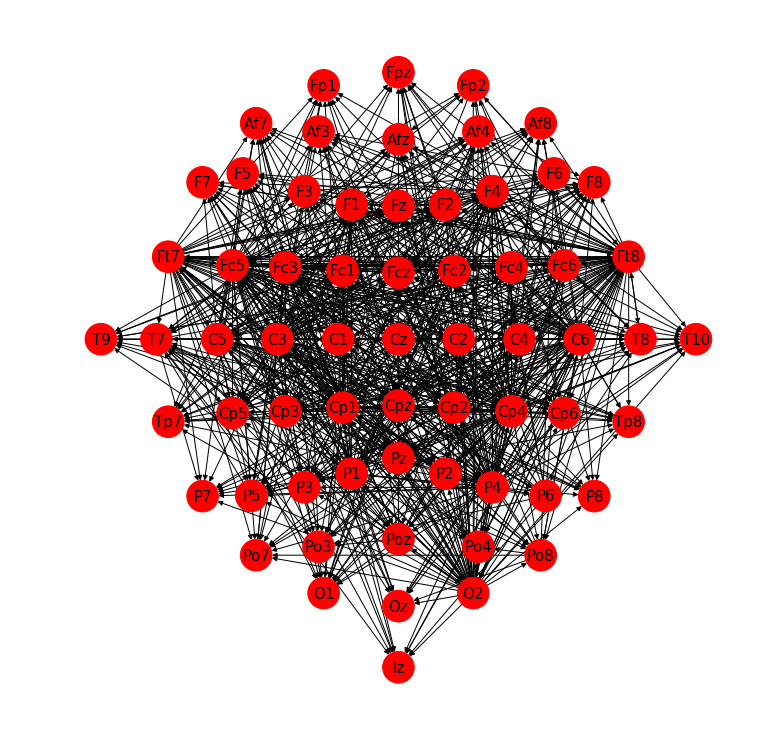

In [537]:
pos = {}
with open("channel_locations.txt") as f:
    next(f)
    c = csv.reader(f)
    for line in c:
        line = line[0]
        line=line.split('        ')
        pos[line[1]] = (float(line[2]), float(line[3]))

# Topographical representation
sub32 = G_32.subgraph(channels)

nx.draw(sub32, with_labels = True, pos=pos, font_size=15, node_size=[1000]*64)

In [424]:
#list(nx.neighbors(G_dtf, 'Af3'))
#list(G_dtf['Fc5'])
nx.number_of_edges(G_32)

819

### Task 4

In [218]:
threshold_19 = con_values[int(len(con_values_19)*0.99):][0]

In [221]:
adj_mat_19 = [ [0 for i in range(19)] for j in range(19)]
for i in range(19):
    for j in range(19):
        if gdtf_significance_19[i][j]>threshold_19:
            adj_mat_19[i][j]=1

In [223]:
G_19 = nx.DiGraph(np.array(adj_mat_19))

In [579]:
from networkx.algorithms import community

communities_generator = community.girvan_newman(G_19) 

top_level_communities = next(communities_generator)
next_level_communities = next(communities_generator)
next_level_communities = sorted(map(sorted, next_level_communities))

print('number of communities:')
print(len(next_level_communities))
print('composition of communities:')
next_level_communities

number of communities:
3
composition of communities:


[[0], [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18], [11]]

### 4.2

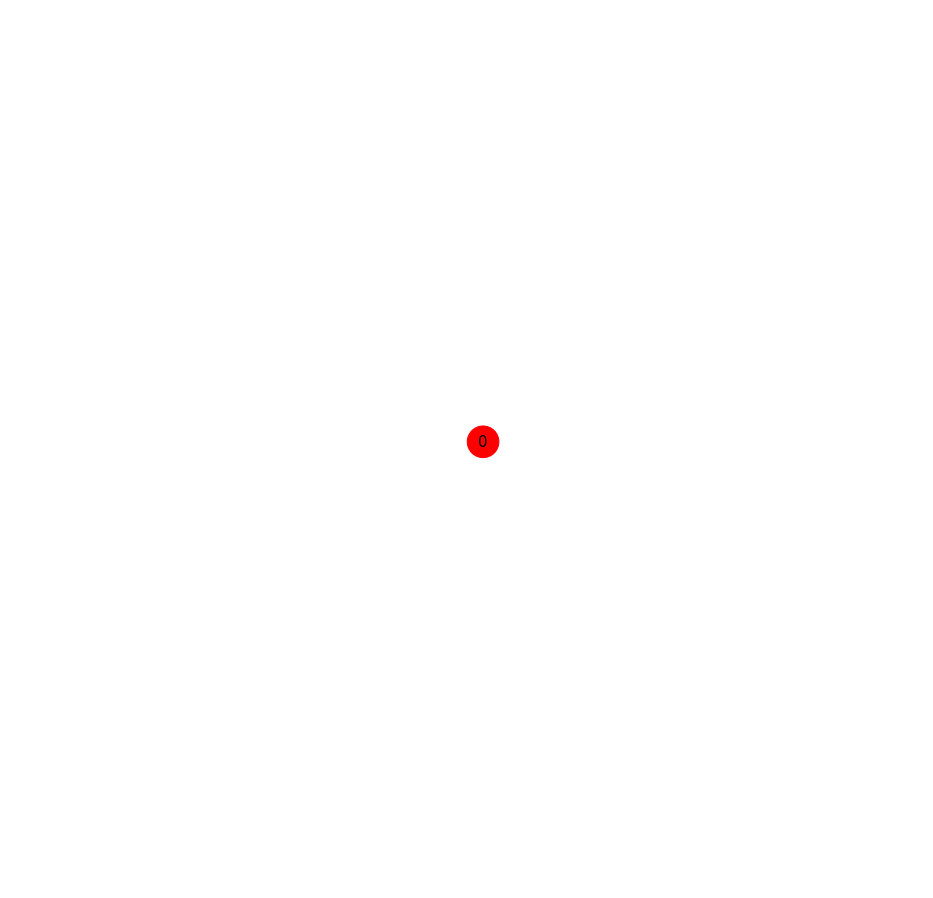

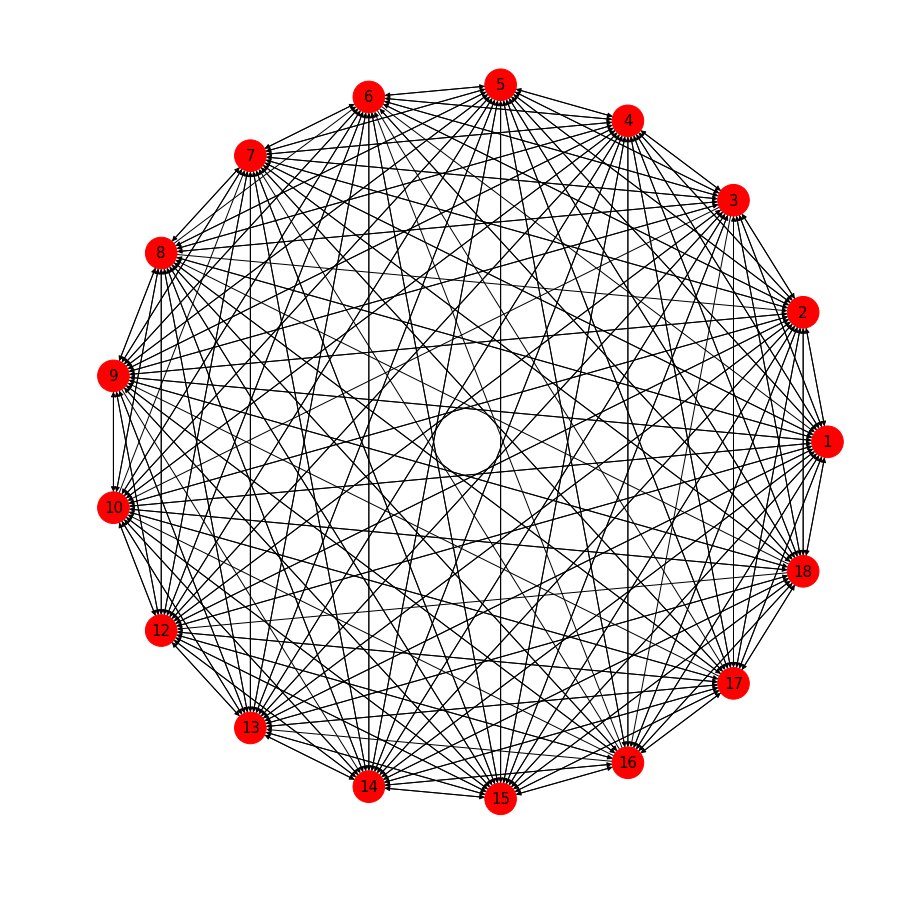

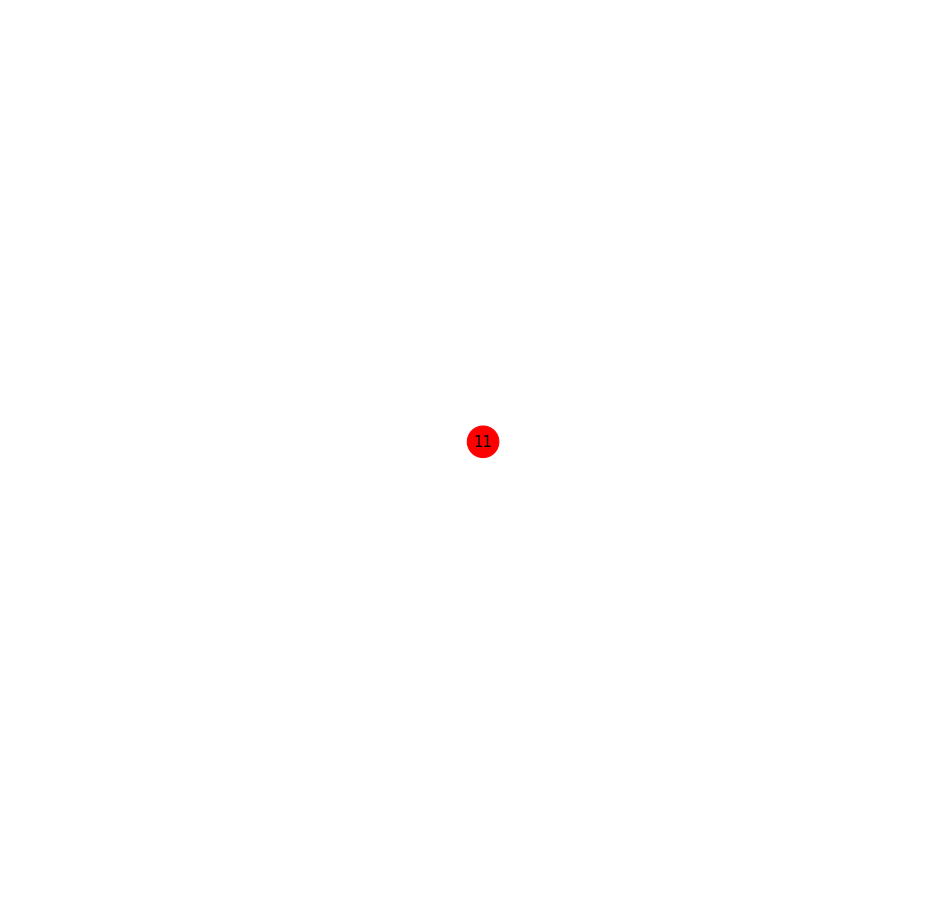

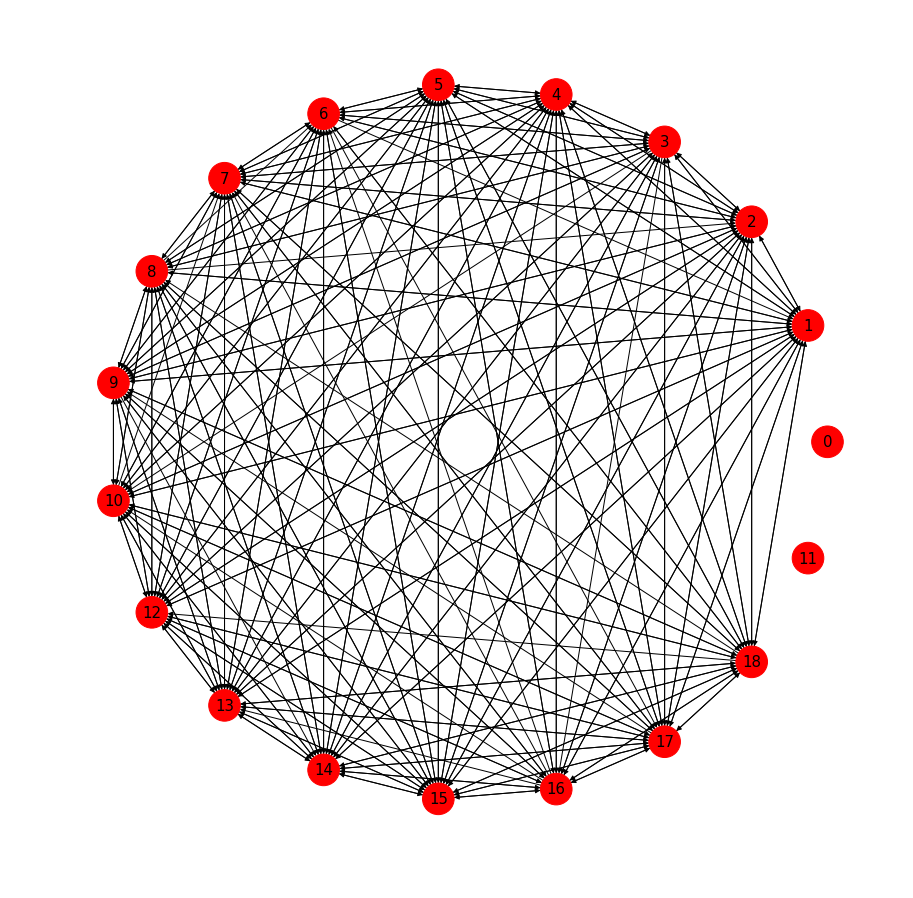

In [580]:
netwx_graphs = []
for e in next_level_communities:
    comm = G_19.subgraph(e)
    netwx_graphs.append(comm)
    pos = nx.circular_layout(comm)
    plt.figure(figsize=(12,12))
    nx.draw(comm, with_labels = True, pos=pos, font_size=15, node_size=[1000]*64)

composed = nx.compose_all(netwx_graphs)

pos = nx.circular_layout(composed)
plt.figure(figsize=(12,12))
nx.draw(composed, with_labels = True,pos=pos, font_size=15, node_size=[1000]*64)

### 4.3

In [ ]:
import matplotlib.colors as colors
import infomap

def findCommunities(G):
    """
    Partition network with the Infomap algorithm.
    Annotates nodes with 'community' id and return number of communities found.
    """
    infomapWrapper = infomap.Infomap("--two-level --directed")

    print("Building Infomap network from a NetworkX graph...")
    for e in G.edges():
        #print(e[0],e[1])
        infomapWrapper.addLink(int(e[0]),int(e[1]))
        #infomapWrapper.addLink(*e)

    print("Find communities with Infomap...")
    infomapWrapper.run();

    tree = infomapWrapper.iterTree

    print("Found %d modules with codelength: %f" % (infomapWrapper.numTopModules(), infomapWrapper.codelength()))

    communities = {}
    print(infomapWrapper, type(infomapWrapper))
    for node in tree.leafIter():
        communities[node.originalLeafIndex] = node.moduleIndex()

    nx.set_node_attributes(G, name='community', values=communities)
    return infomapWrapper.numTopModules()

def drawNetwork(G):
    # position map
    pos = nx.spring_layout(G)
    # community ids
    communities = [v for k,v in nx.get_node_attributes(G, 'community').items()]
    numCommunities = max(communities) + 1
    # color map from http://colorbrewer2.org/
    cmapLight = colors.ListedColormap(['#a6cee3', '#b2df8a', '#fb9a99', '#fdbf6f', '#cab2d6'], 'indexed', numCommunities)
    cmapDark = colors.ListedColormap(['#1f78b4', '#33a02c', '#e31a1c', '#ff7f00', '#6a3d9a'], 'indexed', numCommunities)

    # Draw edges
    nx.draw_networkx_edges(G, pos)

    # Draw nodes
    nodeCollection = nx.draw_networkx_nodes(G,
        pos = pos,
        node_color = communities,
        cmap = cmapLight
    )
    # Set node border color to the darker shade
    darkColors = [cmapDark(v) for v in communities]
    nodeCollection.set_edgecolor(darkColors)

    # Draw node labels
    for n in G.nodes():
        plt.annotate(n,
            xy = pos[n],
            textcoords = 'offset points',
            horizontalalignment = 'center',
            verticalalignment = 'center',
            xytext = [0, 0],
            color = cmapDark(communities[n])
        )

    plt.axis('off')
    # plt.savefig("karate.png")
    plt.show()

G_info=nx.karate_club_graph()
findCommunities(G_19)
drawNetwork(G_19)

## 